In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

### load predicted behaviors

In [2]:
behaviors = load_behaviors('../processed_dataset/behaviors_sni.pkl')

In [3]:
### some params
# bin time 1 minute, change the last  number to 2 for 2 minute bins
num_min = 1
time_bin_size = 60*60*num_min
# take random file to compute total number of bins
n_bins = len(behaviors['B_Baseline_SNI']['Condition1']['file0'])/time_bin_size

# mMORP-hm4di Male
selected_group_exp0 = 'B_Baseline_SNI'
selected_condition_exp0 = 'Condition1'

# mMORP-hm4di Female
selected_group_exp1 = 'B_Baseline_SNI'
selected_condition_exp1 = 'Condition2'

# mMORP-eYFP Male/Female
selected_group_exp2 = 'B_Baseline_SNI'
selected_condition_exp2 = 'Condition3'

selected_groups = [selected_group_exp0, selected_group_exp1, selected_group_exp2]
selected_conditions = [selected_condition_exp0, selected_condition_exp1, selected_condition_exp2]
annotations = ['M mMORP-hm4di', 'F mMORP-hm4di', 'mMORP-eYFP']


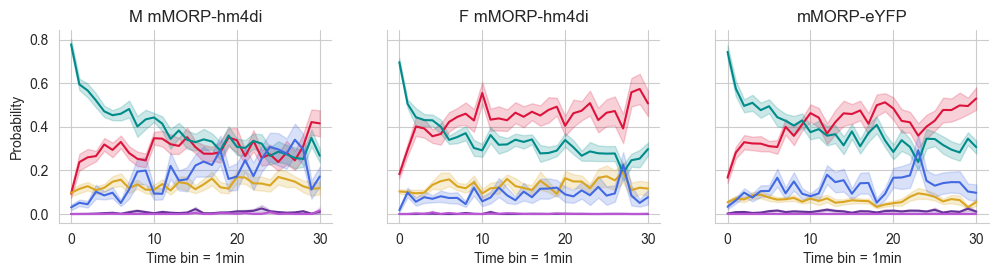

In [4]:
# bin behaviors per params above

rows = 1
cols = len(selected_groups)
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(12, 2.5), sharey=True)
y_to_save = {key: [] for key in annotations}
for selected_group, selected_condition in zip(selected_groups, selected_conditions):
    behavior_ratios_files = {key: np.NAN 
                             for key in range(len(behaviors[selected_group][selected_condition]))}
    
    for f in range(len(behaviors[selected_group][selected_condition])):
        binned_behavs = []
        for bin_n in range(int(n_bins)):
            # get counts paired with unique value
            behavior_ratios = {key: 0 for key in range(len(behavior_names))}
            values, counts = np.unique(
                behaviors[selected_group][selected_condition][f'file{f}'][
                time_bin_size*bin_n:time_bin_size*(bin_n+1)], 
                return_counts=True)
            # normalize to sum = 1
            for i, value in enumerate(values):
                behavior_ratios[value] = counts[i]/sum(counts)
            binned_behavs.append(behavior_ratios)
        # store relative to file number
        behavior_ratios_files[f] = binned_behavs
    # plotting below, compute mean and sem across all files (regardless of sex)
    y_to_save[annotations[count]] = {key: [] for key in behavior_names}
    for b in range(len(behavior_names)):
        y_files = []
        for f in range(len(behavior_ratios_files)):
            y_files.append(np.hstack([behavior_ratios_files[f][bin][b] 
                                      for bin in range(len(behavior_ratios_files[f]))])
                           )
        y = (np.mean(y_files, axis=0))
        y_to_save[annotations[count]][behavior_names[b]] = y.copy()
        x = np.arange(int(n_bins))
        y_sem = (np.std(y_files, axis=0)/np.sqrt(len(behavior_ratios_files)))
        # plot shadederrorbar
        ax[count].plot(x, y, color=behavior_colors[b])
        ax[count].fill_between(x, y-y_sem, y+y_sem, color=behavior_colors[b], alpha=0.2)
    ax[count].set_title(annotations[count])
    ax[count].spines[['top', 'right']].set_visible(False)
    ax[count].set_xlabel(f'Time bin = {num_min}min')
    ax[count].set_xticks(np.arange(0, n_bins, 10))
    
    if count == 0:
        ax[count].set_ylabel('Probability')
    count += 1

In [5]:
df = pd.DataFrame(y_to_save).T
df.to_csv('../processed_dataset/fig4_B_Baseline_SNI/mean_ratio.csv')

### file save, change the extension to change the file format

In [6]:
fig.savefig(f'../figures/fig4_B_Baseline_SNI_behaviors.svg', 
            dpi=600, bbox_inches='tight')